In [91]:
import keras
keras.__version__

'2.14.0'

In [93]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [94]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words
# (among top max_features most common words)
maxlen = 150

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [96]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer,
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_17 (Flatten)        (None, 1200)              0         
                                                                 
 dense_32 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81201 (317.19 KB)
Trainable params: 81201 (317.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 3s 4ms/step - loss: 0.6063 - acc: 0.6938 - val_loss: 0.4415 - val_acc: 0.8252
Epoch 2/15
625/625 [==============================] - 3s 5ms/step - loss: 0.3415 - acc: 0.8637 - val_loss: 0.3238 - val_acc: 0.8632
Epoch 3/15
625/

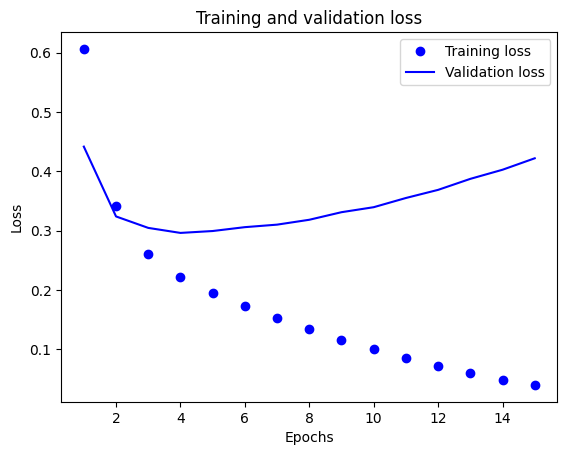

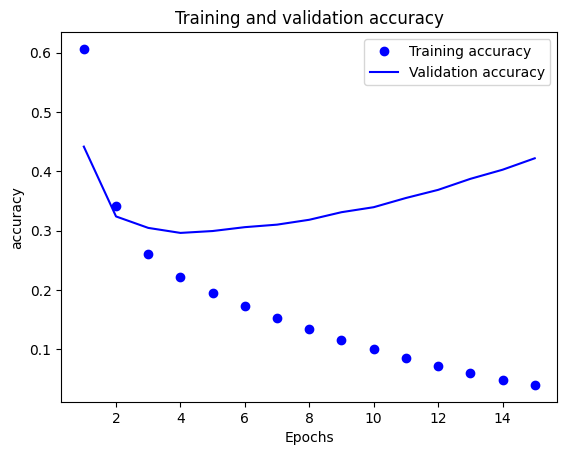

In [97]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

import matplotlib.pyplot as plt
history_dict = history.history
accuracy_values = history_dict["acc"]
val_accuracy_values = history_dict["val_acc"]
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training accuracy")
plt.plot(epochs, val_loss_values, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()



In [98]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)

# Print the test set accuracy
print(f"Test set accuracy: {accuracy}")


782/782 [==============================] - 1s 2ms/step - loss: 0.4235 - acc: 0.8552
Test set accuracy: 0.8551599979400635


### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels
(positive / negative) into a `labels` list:

In [99]:

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4552k      0  0:00:18  0:00:18 --:--:-- 8486k


In [100]:
!rm -r aclImdb/train/unsup

In [101]:
import os

imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise,
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [105]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150  # We will cut reviews after 100 words
training_samples = 100  #  restricting training samples to 100
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number
vectors).

In [106]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [107]:
import os
glove_dir = '/content/gdrive/MyDrive'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [108]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words,
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

### Define a model

We will be using the same model architecture as before:

In [109]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 flatten_18 (Flatten)        (None, 15000)             0         
                                                                 
 dense_33 (Dense)            (None, 32)                480032    
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [110]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer),
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already
learned features.

### Train and evaluate

Let's compile our model and train it:

In [111]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
4/4 [==============================] - 4s 960ms/step - loss: 3.7695 - acc: 0.4700 - val_loss: 0.6923 - val_acc: 0.5325
Epoch 2/10
4/4 [==============================] - 3s 869ms/step - loss: 0.5119 - acc: 0.8000 - val_loss: 0.8266 - val_acc: 0.5081
Epoch 3/10
4/4 [==============================] - 1s 318ms/step - loss: 0.4426 - acc: 0.7700 - val_loss: 1.0067 - val_acc: 0.4976
Epoch 4/10
4/4 [==============================] - 1s 437ms/step - loss: 0.1993 - acc: 0.9300 - val_loss: 1.7408 - val_acc: 0.4962
Epoch 5/10
4/4 [==============================] - 1s 438ms/step - loss: 0.1895 - acc: 0.9400 - val_loss: 1.2890 - val_acc: 0.5096
Epoch 6/10
4/4 [==============================] - 1s 437ms/step - loss: 0.0999 - acc: 0.9700 - val_loss: 0.8122 - val_acc: 0.5506
Epoch 7/10
4/4 [==============================] - 1s 306ms/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.9832 - val_acc: 0.5342
Epoch 8/10
4/4 [==============================] - 1s 317ms/step - loss: 0.0127 - acc: 1.00

Let's plot its performance over time:

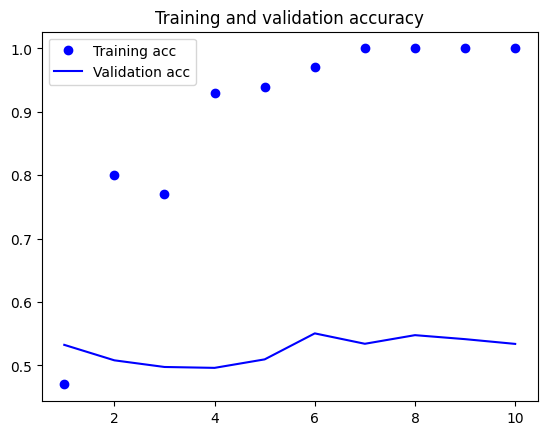

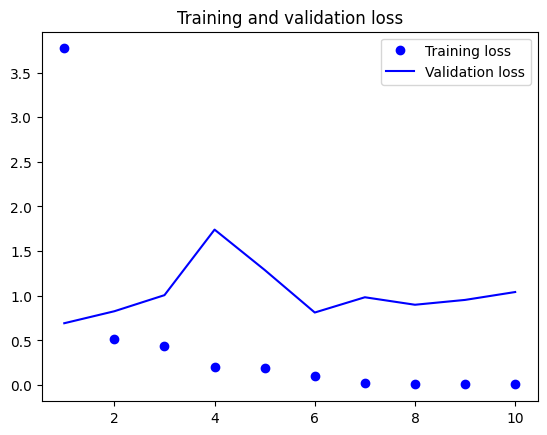

In [112]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 flatten_15 (Flatten)        (None, 15000)             0         
                                                                 
 dense_29 (Dense)            (None, 32)                480032    
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1480065 (5.65 MB)
Trainable params: 1480065 (5.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 2s 493ms/step - loss: 0.7014 - acc: 0.4000 - val_loss: 0.6953 - val_acc: 0.5028
Epoch 2/10
4/4 [=

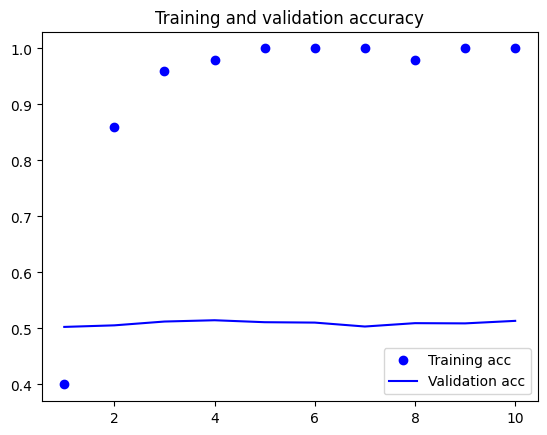

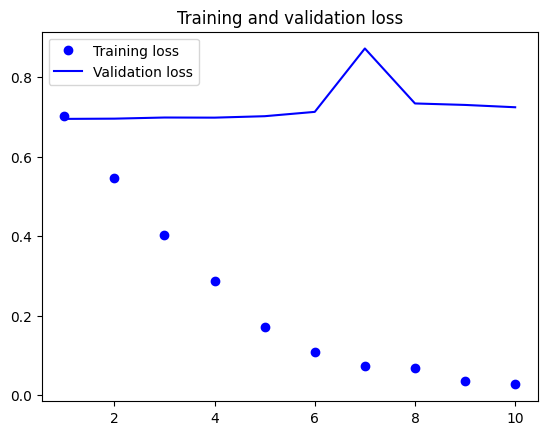

In [88]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]


In [114]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

157/157 [==============================] - 1s 4ms/step - loss: 0.2808 - acc: 0.8902


[0.2808234393596649, 0.8902000188827515]